In [59]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix

from preprocess import (
    lowerColumnsNames,
    textSeriesProcessing,
    labelProcessing,
)

import warnings
warnings.filterwarnings("ignore")

## Importing Data

In [2]:
#Loading Data
train_data = pd.read_csv('data_train.csv', encoding="latin1").iloc[:, 1:]
test_data  = pd.read_csv('data_test.csv', encoding="latin1").iloc[:, 1:]

print('Training data')
print(train_data.head())
print('Testing Data')
print(test_data.head())

Training data
                                        Message_body     Label
0                         Rofl. Its true to its name  Non-Spam
1  The guy did some bitching but I acted like i'd...  Non-Spam
2  Pity, * was in mood for that. So...any other s...  Non-Spam
3               Will ü b going to esplanade fr home?  Non-Spam
4  This is the 2nd time we have tried 2 contact u...      Spam
Testing Data
                                        Message_body Label
0  UpgrdCentre Orange customer, you may now claim...  Spam
1  Loan for any purpose £500 - £75,000. Homeowner...  Spam
2  Congrats! Nokia 3650 video camera phone is you...  Spam
3  URGENT! Your Mobile number has been awarded wi...  Spam
4  Someone has contacted our dating service and e...  Spam


## Data Preprocess

In [3]:
#Changing df columns names
train_data = lowerColumnsNames(train_data)
test_data  = lowerColumnsNames(test_data)

In [4]:
#Splitting data in input and output
training_messages = train_data['message_body']
training_labels = train_data['label']

testing_messages = test_data['message_body']
testing_labels = test_data['label']

#Processing message_body (lowercase, remove url and punctuation, stop words, etc.)
training_messages = textSeriesProcessing(training_messages)
testing_messages  = textSeriesProcessing(testing_messages)

print(training_messages[1])
print(testing_messages[1])

guy bitching acted like id interested buying something else next week gave us free
loan purpose £500  £75000 homeowners  tenants welcome previously refused still help call free 0800 1956669 text back help


In [5]:
#Processing labels (output)
training_label_hot, training_label_encoder = labelProcessing(training_labels)
testing_label_hot, testing_label_encoder = labelProcessing(testing_labels)

print("Trainin One Hot Encoder matrix \n")
print(training_label_hot[:5])

Trainin One Hot Encoder matrix 

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [10]:
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

vocab_size = 10000
max_length = 32
embedding_dim = 16
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_messages)

training_sequences = tokenizer.texts_to_sequences(training_messages)
testing_sequences  = tokenizer.texts_to_sequences(testing_messages)

print(training_messages[1])
print(training_sequences[1])

guy bitching acted like id interested buying something else next week gave us free
[207, 1129, 673, 14, 179, 488, 372, 127, 208, 90, 38, 373, 71, 10]


In [14]:
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding = padding_type, 
                                truncating= trunc_type)

testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding = padding_type, 
                                truncating= trunc_type)

print(training_messages[1])
print(training_padded[1])

guy bitching acted like id interested buying something else next week gave us free
[ 207 1129  673   14  179  488  372  127  208   90   38  373   71   10
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


## Data Description

In [57]:
train_data.describe()

,message_body,label
count,957,957
unique,945,2
top,"Sorry, I'll call later",Non-Spam
freq,4,835


In [58]:
train_data[train_data['message_body'].isnull()]

,message_body,label


## Building the model

In [16]:
#Model Architecture
num_classes = 2
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              17408     
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 178,433
Trainable params: 178,433
Non-trainable params: 0
________________________________________________

In [17]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer= 'adam', metrics = ['accuracy'])

In [18]:
#Training the model
num_epochs = 10
history = model.fit(training_padded, training_label_encoder, epochs= num_epochs, verbose= 2,
                    validation_split=0.10)

Epoch 1/10
27/27 - 2s - loss: 0.5623 - accuracy: 0.8711 - val_loss: 0.3936 - val_accuracy: 0.8854 - 2s/epoch - 66ms/step
Epoch 2/10
27/27 - 0s - loss: 0.3515 - accuracy: 0.8711 - val_loss: 0.3032 - val_accuracy: 0.8854 - 144ms/epoch - 5ms/step
Epoch 3/10
27/27 - 0s - loss: 0.3021 - accuracy: 0.8711 - val_loss: 0.2760 - val_accuracy: 0.8854 - 119ms/epoch - 4ms/step
Epoch 4/10
27/27 - 0s - loss: 0.2572 - accuracy: 0.8711 - val_loss: 0.2376 - val_accuracy: 0.8854 - 142ms/epoch - 5ms/step
Epoch 5/10
27/27 - 0s - loss: 0.1946 - accuracy: 0.9048 - val_loss: 0.1861 - val_accuracy: 0.9062 - 151ms/epoch - 6ms/step
Epoch 6/10
27/27 - 0s - loss: 0.1318 - accuracy: 0.9535 - val_loss: 0.1367 - val_accuracy: 0.9479 - 145ms/epoch - 5ms/step
Epoch 7/10
27/27 - 0s - loss: 0.0806 - accuracy: 0.9803 - val_loss: 0.1040 - val_accuracy: 0.9479 - 121ms/epoch - 4ms/step
Epoch 8/10
27/27 - 0s - loss: 0.0482 - accuracy: 0.9884 - val_loss: 0.0800 - val_accuracy: 0.9479 - 122ms/epoch - 5ms/step
Epoch 9/10
27/27 -

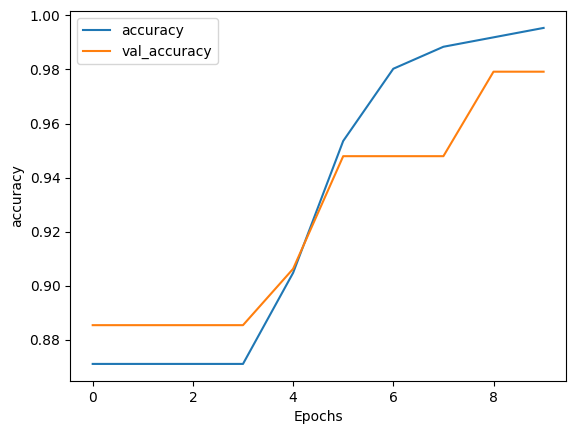

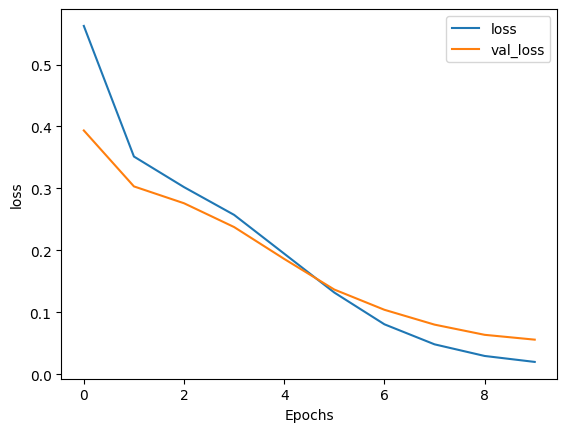

In [19]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Testing the model

In [20]:
test_loss, test_accuracy = model.evaluate(testing_padded, testing_label_encoder)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

4/4 [==============================] - 0s 3ms/step - loss: 0.2334 - accuracy: 0.9120
Test Loss: 0.2334410697221756
Test Accuracy: 0.9120000004768372


In [49]:
predictions = model.predict(testing_padded[:100])
print(predictions[:10])

4/4 [==============================] - 0s 3ms/step
[[0.97752464]
 [0.9227468 ]
 [0.9885512 ]
 [0.99101514]
 [0.51820236]
 [0.96275413]
 [0.9326044 ]
 [0.30982533]
 [0.99153066]
 [0.9888991 ]]


In [50]:
pred = list(map(lambda x: 1 if x>= 0.5 else 0, predictions))

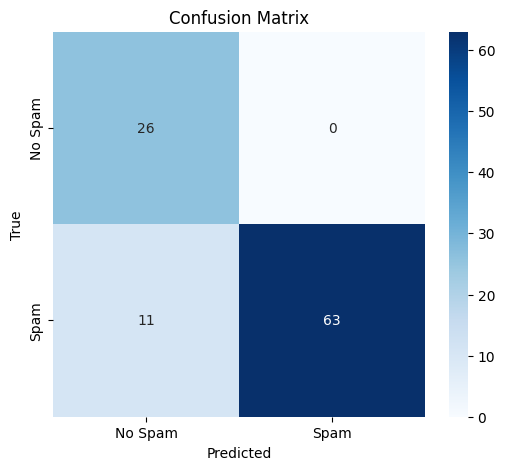

In [53]:
cm = confusion_matrix(list(testing_label_encoder[:100]), pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Demo

In [85]:
def spamDemo(message : pd.Series) -> str :

    message_processed = textSeriesProcessing(message)
    message_sequence = tokenizer.texts_to_sequences(message_processed)
    message_padded = pad_sequences(message_sequence, maxlen=max_length, padding = padding_type, 
                                    truncating= trunc_type)

    message_prediction = model.predict(message_padded)[0][0]

    if message_prediction > 0.5:
        return "The message received is a Spam"
    else:
        return "The message received is not a Spam"


In [90]:
random_index = random.randint(0, test_data.shape[0])
message_text = test_data.iloc[random_index, 0]
message = pd.Series(message_text)

response = spamDemo(message)
print(message_text)
print(response)

1/1 [==============================] - 0s 69ms/step
Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16
The message received is a Spam
